In [1]:
import os
import random

import pandas as pd
import numpy as np
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import _gradient_boosting
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions_pipe_testing import *
from sklearn.metrics import  f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import *
from sklearn.preprocessing import LabelEncoder
from helper_functions_KP import *
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
import math

#Instructions for the pipeline Requires two inputs for training: - Mass spec data with corresponding NP surface characteristics and experimental conditions (time, concentration) - NetsurfP and Biopython data that has been precalculated - X characteristics to predict
pipeline Take mass spec spreadsheet Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration Merge with Proteome data to get file that has Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration,Mass,Length,Sequence Calculate protein features using biopython Merge with NSP data to get all protein features
Split into X and Y dataset with Entries as labels

In [33]:
### Make 3 DFs### Load saved DFs instead of running this cell
#DF 1 All_ files combined
#DF 2 Synth Files ( the 19 UniqueNPs that I ran with my synthesized NPs+some PS NPs)
#DF 3 All_files 30% zeros
multi_files = True  #set to false if you just want to set one  prot_abund_file
in_dir = "Input_data/Proteomic data/Abundance2/"
prot_abund_file = 'Input_data/Proteomic data/abundance/Norm_Intensity_Bovsynth022123.xlsx'
NP_filepath = 'Input_data/NPs/NP_Database2.xlsx'
controls_file = 'Input_data/Proteomic data/controls_combined.xlsx'
uniprot_filepath = 'Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
NSPfilePath = 'Input_data/NetSurfP_data/Combined.xlsx'
cutoff_vals=[0.1,0.2,0.3,0.5]
files = os.listdir(in_dir)
for zerosperrow in cutoff_vals:
    if multi_files == True:
        for i, f in enumerate(files):
            if i == 0:
                raw_MS_data = pd.read_excel(in_dir + f, header=0)
                cols = raw_MS_data.shape[1]
                cutoff = int(zerosperrow * cols)
                print('shape before dropping rows', raw_MS_data.shape)
                raw_MS_data = raw_MS_data.drop(raw_MS_data[(raw_MS_data == 0).sum(axis=1) >= cutoff].index)
                print('shape after dropping rows', raw_MS_data.shape)
                # print(raw_MS_data)
                raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')

            else:

                temp = pd.read_excel(in_dir + f, header=0)
                cols = temp.shape[1]
                cutoff = int(zerosperrow * cols)
                print('shape before dropping rows', raw_MS_data.shape)
                temp = temp.drop(temp[(temp == 0).sum(axis=1) >= cutoff].index)
                print('shape after dropping rows', raw_MS_data.shape)
                temp = pd.melt(temp, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')

                raw_MS_data = pd.concat([raw_MS_data, temp])
                print('final shape after melt', raw_MS_data.shape)
                print('number of zeros in the dataset:',(raw_MS_data == 0).sum().sum())


    else:
        raw_MS_data = pd.read_excel(prot_abund_file, header=0)
        cols = raw_MS_data.shape[1]
        cutoff = int(zerosperrow * cols)
        print('shape beofre dropping rows', raw_MS_data.shape)
        raw_MS_data = raw_MS_data.drop(raw_MS_data[(raw_MS_data == 0).sum(axis=1) >= cutoff].index)
        print('shape after dropping rows', raw_MS_data.shape)
        raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')
    #remove prots that were added due to merge
    raw_MS_data = raw_MS_data.dropna()
    ###Bring in controls (MS data for serums)##
    controls = pd.read_excel(controls_file, header=0)
    MS_data_controls = pd.merge(raw_MS_data, controls, how='left', on='Entry')
    ###Bring in Uniprot_data,NSPdata and NP data##
    uniprot_dat = pd.read_excel(uniprot_filepath, header=0)
    NSP_data = pd.read_excel(NSPfilePath)
    ###Bring in NP data and merge to get complete NP dataset###
    NPUNdata = pd.read_excel(NP_filepath, header=0, sheet_name='NPUNID')
    NPprop = pd.read_excel(NP_filepath, header=0, sheet_name='NP_Props')
    NPdata = pd.merge(NPUNdata, NPprop, how="left", on='NPID')
    # NPdata.dropna(inplace=True)
    #calculate Enrichment
    #####MAYBE add binning here to keep negative results and improve capapbilities######
    # MS_data_controls['Enrichment']= np.log2(MS_data_controls['Abundance']/MS_data_controls['Abundance_Controls'])
    # MS_data=MS_data_controls.drop(columns=['Abundance','Abundance_Controls'])
    raw_prop_data = pd.merge(MS_data_controls, uniprot_dat.drop_duplicates(subset=['Entry']), how='left', on='Entry')
    Protein_data_complete = pd.merge(raw_prop_data, NSP_data.drop_duplicates(subset=['Entry']), how='left',
                                 on='Entry')
    #merges netsurfp features and biopython features
    Protein_data_complete.fillna(0, inplace=True)
    # print('Sample Nums in Protein Data',Protein_data_complete['Sample_num'])
    data_complete = pd.merge(Protein_data_complete, NPdata, how='inner', on='Sample_num')
    data_complete.fillna(0, inplace=True)
    #create ordinal variables for the core materials and surface ligands
    le = LabelEncoder()
    data_complete['Core Material'] = le.fit_transform(data_complete['Core Material'])
    data_complete['Surface_Ligand'] = le.fit_transform(data_complete['Surface_Ligand'])
    #shuffle data using sample
    data_complete = data_complete.sample(frac=1)

    data_complete.drop(columns=['notes', 'Notes'], inplace=True)

    data_complete.to_excel("Input_data/Save_files/df_3_all_"+str(int(zerosperrow*100))+"%zeros.xlsx", index=False)


shape before dropping rows (474, 14)
shape after dropping rows (7, 14)
shape before dropping rows (91, 3)
shape after dropping rows (91, 3)
final shape after melt (3061, 3)
number of zeros in the dataset: 65
shape before dropping rows (474, 14)
shape after dropping rows (13, 14)
shape before dropping rows (169, 3)
shape after dropping rows (169, 3)
final shape after melt (4844, 3)
number of zeros in the dataset: 298
shape before dropping rows (474, 14)
shape after dropping rows (27, 14)
shape before dropping rows (351, 3)
shape after dropping rows (351, 3)
final shape after melt (6841, 3)
number of zeros in the dataset: 752
shape before dropping rows (474, 14)
shape after dropping rows (52, 14)
shape before dropping rows (676, 3)
shape after dropping rows (676, 3)
final shape after melt (10191, 3)
number of zeros in the dataset: 2066


In [ ]:
# Large OG Pipeline # Move lower #

#Editable Variables
#list of test filters
# zerosperrow = 0.3
# multi_files = True  #set to false if you just want to set one  prot_abund_file
# rfecv_ = True  #True_runs RFECV
# rfe_ = False     #True runs Recursive feature elimination
# abund_controls = True # True keeps the serum as an input feature
# splits = 10     #number of splits for cross validation across QC methods and feature selection methods
# in_dir = "Input_data/Proteomic data/Abundance2/"
# prot_abund_file = 'Input_data/Proteomic data/Abundance2/Norm_Intensity _all20230403.xlsx'
# NP_filepath = 'Input_data/NPs/NP_Database.xlsx'
# controls_file = 'Input_data/Proteomic data/controls_combined.xlsx'
# uniprot_filepath = 'Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
# NSPfilePath = 'Input_data/NetSurfP_data/Combined.xlsx'
#
# scorings=['r2','neg_mean_squared_error','mean_absolute_error']
# RFE_Feats = 40
# model = RandomForestRegressor(n_estimators=80)
# # model=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
# summary_tmp=[]
# for z in scorings:
#     id = 'Con_drop_' +str(z)+ '_30' + '%zeros'
#     # take files in_dir and combine then into a pandas df (raw_MS_data) ###USE when combining multiple datasets####
#     # melt the df to make it an accession number, NPUNID, Abundance dataset before combining
#     files = os.listdir(in_dir)
#     if multi_files == True:
#         for i, f in enumerate(files):
#             if i == 0:
#                 raw_MS_data = pd.read_excel(in_dir + f, header=0)
#                 cols = raw_MS_data.shape[1]
#                 cutoff = int(zerosperrow * cols)
#                 print('shape before dropping rows', raw_MS_data.shape)
#                 raw_MS_data = raw_MS_data.drop(raw_MS_data[(raw_MS_data == 0).sum(axis=1) >= cutoff].index)
#                 print('shape after dropping rows', raw_MS_data.shape)
#                 # print(raw_MS_data)
#                 raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')
#
#             else:
#
#                 temp = pd.read_excel(in_dir + f, header=0)
#                 cols = temp.shape[1]
#                 cutoff = int(zerosperrow * cols)
#                 print('shape before dropping rows', raw_MS_data.shape)
#                 temp = temp.drop(temp[(temp == 0).sum(axis=1) >= cutoff].index)
#                 print('shape after dropping rows', raw_MS_data.shape)
#                 temp = pd.melt(temp, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')
#
#                 raw_MS_data = pd.concat([raw_MS_data, temp])
#                 print('final shape after melt', raw_MS_data.shape)
#                 print('number of zeros in the dataset:',(raw_MS_data == 0).sum().sum())
#
#
#     else:
#         raw_MS_data = pd.read_excel(prot_abund_file, header=0)
#         cols = raw_MS_data.shape[1]
#         cutoff = int(zerosperrow * cols)
#         print('shape beofre dropping rows', raw_MS_data.shape)
#         raw_MS_data = raw_MS_data.drop(raw_MS_data[(raw_MS_data == 0).sum(axis=1) >= cutoff].index)
#         print('shape after dropping rows', raw_MS_data.shape)
#         raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')
#     #remove prots that were added due to merge
#     raw_MS_data = raw_MS_data.dropna()
#     ###Bring in controls (MS data for serums)##
#     controls = pd.read_excel(controls_file, header=0)
#     MS_data_controls = pd.merge(raw_MS_data, controls, how='left', on='Entry')
#     ###Bring in Uniprot_data,NSPdata and NP data##
#     uniprot_dat = pd.read_excel(uniprot_filepath, header=0)
#     NSP_data = pd.read_excel(NSPfilePath)
#     ###Bring in NP data and merge to get complete NP dataset###
#     NPUNdata = pd.read_excel(NP_filepath, header=0, sheet_name='NPUNID')
#     NPprop = pd.read_excel(NP_filepath, header=0, sheet_name='NP_Props')
#     NPdata = pd.merge(NPUNdata, NPprop, how="left", on='NPID')
#     NPdata.dropna(inplace=True)
#     #calculate Enrichment
#     #####MAYBE add binning here to keep negative results and improve capapbilities######
#     # MS_data_controls['Enrichment']= np.log2(MS_data_controls['Abundance']/MS_data_controls['Abundance_Controls'])
#     # MS_data=MS_data_controls.drop(columns=['Abundance','Abundance_Controls'])
#     raw_prop_data = pd.merge(MS_data_controls, uniprot_dat.drop_duplicates(subset=['Entry']), how='left', on='Entry')
#     Protein_data_complete = pd.merge(raw_prop_data, NSP_data.drop_duplicates(subset=['Entry']), how='left',
#                                      on='Entry')
#     #merges netsurfp features and biopython features
#     Protein_data_complete.fillna(0, inplace=True)
#     data_complete = pd.merge(Protein_data_complete, NPdata, how='inner', on='Sample_num')
#     data_complete.fillna(0, inplace=True)
#     #create ordinal variables for the core materials and surface ligands
#     le = LabelEncoder()
#     data_complete['Core Material'] = le.fit_transform(data_complete['Core Material'])
#     data_complete['Surface_Ligand'] = le.fit_transform(data_complete['Surface_Ligand'])
#     #shuffle data using sample
#     data_complete = data_complete.sample(frac=1)
#     #set labels (what we are trying to predict) as Abundance
#     label_abund_df = data_complete['Abundance'].copy()
#     label_abund = np.ravel(label_abund_df)
#     NPIDs=data_complete['NPUNID'].copy()
#     data_complete.drop(columns=['notes', 'Notes', 'NPUNID'], inplace=True)
#
#     #make it one dimenisional
#     #drop qualitative, not neccessary, and label columns
#     #create df without bonus NSP columns (remove total_exposed) There are too sets of features total_exposed and exposed_exposed
#     to_drop = data_complete.filter(like='total_exposed_')
#     data_complete.drop(columns=to_drop, inplace=True)
#     df = data_complete.drop(
#         ['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5',
#          'Raw_FileID'], axis=1)
#     if abund_controls == False:
#         df.drop(columns=['Abundance_Controls'], inplace=True)
#
#     df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
#     df_out.to_excel("Input_data/Save_files/df_whole_"+id+".xlsx")

In [6]:
#Sample code for loading saved DF and dropping appropriate columns before running### Also For running RFECV and saving the reduced df
df_filepath='Input_data/Save_files/df_1_all.xlsx'
id='04232023'
df = pd.read_excel(df_filepath, header=0)
labels_df= df['Abundance'].copy()
id_col= df['NPUNID'].copy()
label_abund=np.ravel(labels_df)
model=RandomForestRegressor(n_estimators=100)
splits=10
scoring='neg_mean_squared_error'
df=df.drop(columns=['Entry', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID'])
import math

start = 0.0001
stop = 1
num_points = 10
# Calculate the common difference between consecutive terms in the series
common_diff = (math.log(stop) - math.log(start)) / (num_points - 1)
# Generate the logarithmic series as a list
Abund_filter = [start * math.exp(i * common_diff) for i in range(num_points)]
# model = RandomForestRegressor(n_estimators=80)
# summary_tmp=[]
for i in Abund_filter:
    df_out= df[df['Abundance']>=i].copy()
# df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2,scoring=scoring)

    df_out.to_excel("Input_data/Save_files/Abund_Filters/df_1_all"+str(i)+".xlsx")


In [2]:
df_filepath='Input_data/Save_files/df_2_Synth.xlsx'
df = pd.read_excel(df_filepath, header=0)
df

,Entry,Sample_num,Abundance,Abundance_Controls,Unnamed: 5,Sequence,Length,Mass,frac_aa_A,frac_aa_C,...,Dh_core,Dh_functionalized,Shaken,Centrifuged,ProteinID,Protein Source,NP_incubation Concentration (mg/mL),Incubation Concentration (mg/ml),Incubation Time (minutes),Temperature
0,Q3SWW8,46,0.000000,0.004931,0,MLAPRGATFLLLHLALQPWLGAGAQATPQVFDLLPSASQRLNPSVL...,961,105974,0.050989,0.048907,...,229,291,1,0,1,FBS,5.0,40,30,25
1,P13213,31,0.000000,0.000000,0,MRAWIFFLLCLAGRALAAPQQEALPDETEVVEETVAEVAEVPVGAN...,303,34613,0.062706,0.049505,...,221,221,1,1,1,FBS,4.0,4,30,25
2,Q2KJF1,46,0.119162,0.802977,0,MSAWAALLLLWGLSLSPVTEQATFFDPRPSLWAEAGSPLAPWADVT...,503,53554,0.109344,0.019881,...,229,291,1,0,1,FBS,5.0,40,30,25
3,P10103,39,0.000000,0.000000,0,MGKGDPKKPRGKMSSYAFFVQTCREEHKKKHPDASVNFSEFSKKCS...,215,24908,0.088372,0.013953,...,149,271,1,0,1,FBS,5.0,40,30,25
4,P13135,49,0.004763,0.000000,0,MFLVNSFLKGGGGGGGGGGLGGGLGNVLGGLISGAGGGGGGGGGGG...,263,27931,0.064639,0.007605,...,221,266,1,1,1,FBS,2.4,40,30,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7557,P01252,37,0.000000,0.000000,0,MSDAAVDTSSEITTKDLKEKKEVVEEAENGREAPANGNANEENGEQ...,110,12072,0.109091,0.000000,...,229,316,1,0,1,FBS,5.0,40,30,25
7558,P81644,32,0.133251,0.004621,0,MKLLALTVLLLTICGLEGALVRRQAEESNLQSLVSQYFQTVADYGK...,100,11202,0.090000,0.010000,...,221,221,1,1,1,FBS,4.0,40,30,25
7559,P02070,40,0.004355,0.000583,0,MLTAEEKAAVTAFWGKVKVDEVGGEALGRLLVVYPWTQRFFESFGD...,145,15954,0.110345,0.006897,...,229,218,1,0,1,FBS,5.0,40,30,25
7560,Q3MHL7,32,0.002787,0.000000,0,MAAVKTLNPKAEVARAQAALAVNISAARGLQDVLRTNLGPKGTMKM...,531,57956,0.101695,0.015066,...,221,221,1,1,1,FBS,4.0,40,30,25


In [5]:
df['NPUNID'].unique()

array([32, 17, 25, 35, 34, 21, 18, 29, 26, 28, 20, 24, 33, 23, 27, 31, 19,
       30, 22], dtype=int64)

In [ ]:
## Run RFECV through each different condition (zeros and abund filters)##

in_dir='Input_data/Save_files/ZerosReduced/'
files=os.listdir(in_dir)
files
for file in files:
    filepath=in_dir+file
    id=file[:-10]
    # print(id)
    # print(filepath)
    df= pd.read_excel(filepath,header=0)
    labels_df= df['Abundance'].copy()
    id_col= df['NPUNID'].copy()
    label_abund=np.ravel(labels_df)
    model=RandomForestRegressor(n_estimators=100)
    splits=5
    df=df.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID','Abundance_Controls'])
    df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2)
    df_out=pd.concat([df, id_col,labels_df], axis=1)
    df_out.to_excel(in_dir+id+'RFECV.xlsx',index=False)



In [22]:
##Sample code for editing and making new dataframes###
in_dir='Input_data/Save_files/'
# files=os.listdir(in_dir)
file='/df_1_all.xlsx'
# for file in files:
filepath=in_dir+file
df= pd.read_excel(filepath, header=0)
df=df.loc[df['Abundance']!=0]
to_drop = df.filter(like='total_exposed_')
# print(to_drop)
df= df.drop(columns=to_drop).copy()
df.to_excel(filepath,index=False)
print('finished', file)

       fraction_total_exposed_A  fraction_total_exposed_C  \
0                      0.029018                  0.000000   
1                      0.017972                  0.001284   
2                      0.072165                  0.010309   
3                      0.019608                  0.000000   
4                      0.030000                  0.010000   
...                         ...                       ...   
25751                  0.032479                  0.007692   
25752                  0.033333                  0.000000   
25753                  0.029138                  0.003497   
25754                  0.035124                  0.004132   
25755                  0.020067                  0.000000   

       fraction_total_exposed_D  fraction_total_exposed_E  \
0                      0.037946                  0.089286   
1                      0.046213                  0.055199   
2                      0.037801                  0.054983   
3                      

In [25]:
##Run RFE and Scorer on each file in a given directory -- Outputs feat importance and score summaries for RFR##
in_dir='Input_data/Save_files/Abund_Filters/'
files=os.listdir(in_dir)

model=RandomForestRegressor(n_estimators=100)
# df_filepath='Input_data/Save_files/df_1_all.xlsx'

summary_tmp=[]
feats=[]
for file in files:
    filepath=in_dir+file
    df = pd.read_excel(filepath, header=0)
    identifier=file[:-5]
    labels_df= df['Abundance'].copy()
    id_col= df['NPUNID'].copy()
    label_abund=np.ravel(labels_df)
    label_abund=np.log2(label_abund)
    # df=df.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID','Abundance_Controls'])
    # df=df.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID'])
    df=df.drop(columns='Abundance_Controls')
    df=df.drop(columns=['Abundance','NPUNID','BatchID','Unnamed: 0'])
    step = 3
    selector = RFE(model, n_features_to_select=15, step=step)
    selector = selector.fit(df, label_abund)
    feat_list = selector.get_feature_names_out()
    df = df[feat_list].copy()
    model.fit(df,labels_df)
    tmp2,tmp3=scorer(df, label_abund, model, identifier, 10)
    summary_tmp.append(tmp2)
    feats.append(tmp3)
# lasso_feature_selection(df, label_abund, id)
summary=pd.concat(summary_tmp,axis=0)
feat_summary=feats[0]
for d in feats[1:]:
    feat_summary=feat_summary.merge(d, on='Features',how='outer')
feat_summary.to_excel('Output_data/Feats_AbundFilters_log2.xlsx', index=False)
summary.to_excel('Output_data/Scores_AbundFilters_log2.xlsx', index=False)
print('done')


Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
done


In [5]:
summary=pd.concat(summary_tmp,axis=0)
feat_summary=feats[0]
for d in feats[1:]:
    feat_summary=feat_summary.merge(d, on='Features',how='outer')
feat_summary.to_excel('Output_data/Feats_Zeros_removed_CA.xlsx', index=False)
summary.to_excel('Output_data/Scores_Zeros_removed_CA.xlsx', index=False)

In [ ]:
df2=RFECV_plot_yb(df,label_abund,5,1)

In [3]:
df_filepath='Input_data/Save_files/df_1_all.xlsx'
id='04232023'
df = pd.read_excel(df_filepath, header=0)
labels_df= df['Abundance'].copy()
id_col= df['NPUNID'].copy()
label_abund=np.ravel(labels_df)
model=RandomForestRegressor(n_estimators=100)
print('here')
df=df.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID','Abundance_Controls'])

selector = RFE(model, n_features_to_select=50, step=3)
print('start')
selector = selector.fit(df, label_abund)
print('fit complete')
selector.support_
ranking = selector.ranking_
feat_list = selector.get_feature_names_out()
df = df[feat_list]
df_out=pd.concat([df, id_col,labels_df],axis=1)
df_out.to_excel("Input_data/Save_files/df_1_all_RFE50_RFR.xlsx",index=False)

NameError: name 'pd' is not defined

In [ ]:
# Standard Pipeline###


# Data to record#
#MSE,Pearson,R2,number of features => Scorer
#Feature importance/Features used=> Scorer, but send out separate df for those

#Editable Variables
#list of test filters
rfecv_ = True  #True_runs RFECV
rfe_ = False     #True runs Recursive feature elimination
abund_controls = False # True keeps the serum as an input feature
splits = 10     #number of splits for cross validation across QC methods and feature selection methods
# scorings=['r2','neg_mean_squared_error','mean_absolute_error']
# RFE_Feats = 40
model = RandomForestRegressor(n_estimators=80)

df_filepath='Input_data/Save_files/df_1_all_RFE50_RFR.xlsx'
df = pd.read_excel(df_filepath, header=0)
labels_df= df['Abundance'].copy()
id_col= df['NPUNID'].copy()
label_abund=np.ravel(labels_df)
NPIDs=np.ravel(id_col)
id='RFR_RFECV_100%'
# df=df.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID'])
df=df.drop(columns=['Abundance','NPUNID'],axis=1)
# if abund_controls == False:
#     df.drop(columns=['Abundance_Controls'], inplace=True)

# model=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
summary_tmp=[]
# for z in scorings:
    #Run PCA to seee how data differentiates#
PCA_plot(df,NPIDs,id)
#use recursive feature elimination with Random Forest Regression as the estimator to select top 45 important features
if rfe_ == True:
    step = 2
    estimator = RandomForestRegressor(n_estimators=100)
    selector = RFE(estimator, n_features_to_select=RFE_Feats, step=step)
    selector = selector.fit(df, label_abund)
    selector.support_
    ranking = selector.ranking_
    feat_list = selector.get_feature_names_out()
    df = df[feat_list]
    df_out=pd.concat([df, NPIDs,labels_df],axis=1)
    df_out.to_excel("Input_data/Save_files/df_RFE40_"+id+".xlsx")

#run Recursive feature elimination with cross validation
if rfecv_ == True:
    df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2)
    df_out=pd.concat([df, NPIDs,labels_df],axis=1)
    df_out.to_excel("Input_data/Save_files/df_RFECV(50)_"+id+".xlsx")
#Quality control
scram_score(df, label_abund, model, id, 0.2)
# feat_drop(df, label_abund, model, id, 0.2)
feat_drop_multifold(df, label_abund, model, id, 0.2, folds=splits)
tmp2=scorer(df, label_abund, model, id, 10)
zeros=(raw_MS_data['Abundance']==0).sum()
percent_zeros=zeros/raw_MS_data.shape[0]
tmp2['TotalZeros']=zeros
tmp2['Percent_zeros']=percent_zeros
summary_tmp.append(tmp2)
# lasso_feature_selection(df, label_abund, id)
summary=pd.concat(summary_tmp,axis=0)
summary.to_excel('Output_data/'+id+'.xlsx', index=False)
print('done')


PCA Ran successfully


In [25]:
df_filepath='Input_data/Save_files/df_1_no0.xlsx'
df = pd.read_excel(df_filepath, header=0)
Min_Control=df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
Min_Control

1.586079417413907e-05

In [26]:
### Running Binary Classification systems and seeing what abund threshold is the best for performance##

abund_thresh=[-2,-1,-0.5,0.25,0.5,0.75,1,2,3,4]
df_filepath='Input_data/Save_files/df_1_no0.xlsx'
df = pd.read_excel(df_filepath, header=0)
Min_Control=df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
df['Abundance_Controls'].replace(0,Min_Control,inplace=True)
df['Enrich']= np.log2(df['Abundance']/df['Abundance_Controls'])
# df = df.replace(np.inf,10)
model=RandomForestClassifier()
# id='RFR_AFilter_'+str(i)+'NoCon'
# Create an empty pandas DataFrame to store the evaluation metrics
eval_df = pd.DataFrame(columns=['Abund Thresh', 'F1', 'AUROC', 'Accuracy', 'Precision', 'Recall'])
df=df.drop(columns=['Entry', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num','Raw_FileID','BatchID'])
df=df.drop(columns=['Abundance_Controls','Abundance'])

# Iterate through multiple iterations of model training and testing
for i in abund_thresh:
    df_a=df.copy()
    df_a['binary_target']= df_a['Enrich'].apply(lambda t: 1 if t>=i else 0)
    labels_df = df_a['binary_target'].copy()
    # id_col= df_a['NPUNID'].copy()
    label_binary=np.ravel(labels_df)
    df_a=df_a.drop(columns=['NPUNID','binary_target','Enrich']).copy()

    step = 2
    RFE_Feats=20
    selector = RFE(model, n_features_to_select=RFE_Feats, step=step)
    selector = selector.fit(df_a, label_binary)
    selector.support_
    ranking = selector.ranking_
    feat_list = selector.get_feature_names_out()
    df_a = df_a[feat_list].copy()

    x_train, x_test, y_train, y_test = train_test_split(df_a, label_binary, test_size=0.3, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Append a new row to the eval_df DataFrame with the evaluation metrics for this iteration
    eval_df = eval_df.append({'Abund Thresh': i,
                              'F1': f1,
                              'AUROC': auroc,
                              'Accuracy': accuracy,
                              'Precision': precision,
                              'Recall': recall}, ignore_index=True)

eval_df.to_excel('Output_data/AbundThresholdingRFC2.xlsx', index=False)



C:\Users\kmp95\AppData\Local\Temp\ipykernel_24100\2291417116.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_df = eval_df.append({'Abund Thresh': i,
C:\Users\kmp95\AppData\Local\Temp\ipykernel_24100\2291417116.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_df = eval_df.append({'Abund Thresh': i,
C:\Users\kmp95\AppData\Local\Temp\ipykernel_24100\2291417116.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_df = eval_df.append({'Abund Thresh': i,
C:\Users\kmp95\AppData\Local\Temp\ipykernel_24100\2291417116.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_df = eval_df.append({'Abund Thresh': i,
C:\Users

PermissionError: [Errno 13] Permission denied: 'Output_data/AbundThresholdingRFC2.xlsx'

In [35]:
model.feature_importances_

array([0.04243641, 0.04714033, 0.04240516, 0.04129702, 0.05267255,
       0.05224468, 0.05554752, 0.0344671 , 0.05503526, 0.05674049,
       0.04156461, 0.04837206, 0.03950628, 0.06814819, 0.0418631 ,
       0.04528183, 0.05187392, 0.06923995, 0.06937306, 0.04479048])

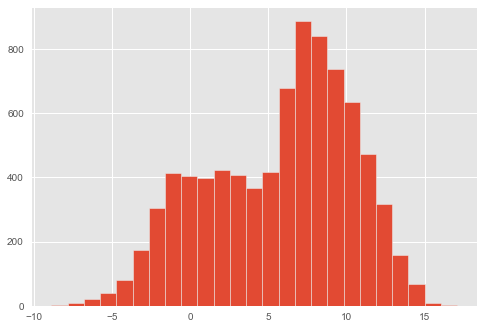

In [28]:
plt.hist(df['Enrich'],bins=25)
# plt.xlim(-2,2)

plt.savefig('Output_data/Enrich_Hist.png')
plt.show()

In [17]:
df

,Length,Mass,frac_aa_A,frac_aa_C,frac_aa_D,frac_aa_E,frac_aa_F,frac_aa_G,frac_aa_H,frac_aa_I,...,Dh_core,Dh_functionalized,Shaken,Centrifuged,ProteinID,NP_incubation Concentration (mg/mL),Incubation Concentration (mg/ml),Incubation Time (minutes),Temperature,Enrich
0,291,31570,0.082474,0.061856,0.044674,0.054983,0.020619,0.099656,0.027491,0.013746,...,105,105,0,0,1,3.2,4.0,1440,25,10.000000
1,255,28405,0.094118,0.015686,0.066667,0.090196,0.035294,0.074510,0.019608,0.050980,...,149,229,1,0,1,5.0,40.0,30,25,10.000000
2,145,15859,0.103448,0.013793,0.055172,0.068966,0.068966,0.075862,0.034483,0.006897,...,105,105,0,0,1,3.2,40.0,1440,25,-0.580601
3,225,24805,0.093333,0.013333,0.106667,0.093333,0.022222,0.066667,0.008889,0.040000,...,149,229,1,0,1,5.0,40.0,30,25,10.000000
4,1495,165853,0.065552,0.016054,0.037458,0.061538,0.046154,0.058863,0.023411,0.054181,...,680,680,1,1,2,125.0,0.2,60,25,-0.250075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8259,175,19988,0.085714,0.005714,0.068571,0.085714,0.045714,0.074286,0.034286,0.017143,...,149,226,1,0,1,5.0,4.0,30,25,10.000000
8260,444,50244,0.047297,0.024775,0.067568,0.056306,0.038288,0.083333,0.024775,0.063063,...,230,230,1,0,1,3.2,4.0,30,25,4.407132
8261,432,47638,0.092593,0.020833,0.057870,0.064815,0.025463,0.083333,0.027778,0.069444,...,221,221,1,1,1,4.0,4.0,30,25,10.000000
8262,240,27498,0.058333,0.016667,0.045833,0.091667,0.041667,0.050000,0.016667,0.029167,...,441,441,1,1,2,200.0,0.2,60,25,3.316236


In [ ]:
###Filtering Abundance to see if i stick to higher abundance I get better performance##
rfecv_ = False  #True_runs RFECV
rfe_ = True     #True runs Recursive feature elimination
abund_controls = False # True keeps the serum as an input feature
splits = 10     #number of splits for cross validation across QC methods and feature selection methods

df_filepath='Input_data/Save_files/df_1_all.xlsx'
id='04232023'
df = pd.read_excel(df_filepath, header=0)
labels_df= df['Abundance'].copy()
id_col= df['NPUNID'].copy()
label_abund=np.ravel(labels_df)
model=RandomForestRegressor(n_estimators=100)
print('here')
df=df.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID','Abundance_Controls'])

df_filepath = 'Input_data/Save_files/df_1_all.xlsx'
df_a = pd.read_excel(df_filepath, header=0)
df_a=df_a.drop(columns=['Entry', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID'])
# scorings=['r2','neg_mean_squared_error','neg_mean_absolute_error']
RFE_Feats = 15
import math

start = 0.0001
stop = 1
num_points = 15

# Calculate the common difference between consecutive terms in the series
common_diff = (math.log(stop) - math.log(start)) / (num_points - 1)

# Generate the logarithmic series as a list
Abund_filter = [start * math.exp(i * common_diff) for i in range(num_points)]
model = RandomForestRegressor(n_estimators=80)
summary_tmp=[]
for i in Abund_filter:
    df= df_a[df_a['Abundance']>=i]
    id='RFR_AFilter_'+str(i)+'NoCon'
    labels_df= df['Abundance'].copy()
    id_col= df['NPUNID'].copy()
    label_abund=np.ravel(labels_df)
    df.drop(columns=['Abundance','NPUNID'],inplace=True)
    if abund_controls == False:
        df.drop(columns=['Abundance_Controls'], inplace=True)
    #run Recursive feature elimination with cross validation
    if rfecv_ == True:
        df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2,scoring=z)
        # df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        # df_out.to_excel("Input_data/Save_files/df_RFECV(40)_"+id+".xlsx")
    #Run Recursive feature elimination to remove down to RFE_Feats
    if rfe_ == True:
        step = 2
        selector = RFE(model, n_features_to_select=RFE_Feats, step=step)
        selector = selector.fit(df, label_abund)
        selector.support_
        ranking = selector.ranking_
        feat_list = selector.get_feature_names_out()
        df = df[feat_list]
        # df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        # df_out.to_excel("Input_data/Save_files/df_RFE40_"+id+".xlsx")
    tmp2=scorer(df, label_abund, model, id, 10)
    tmp2['Abundance Filter']=i

    summary_tmp.append(tmp2)

    summary=pd.concat(summary_tmp,axis=0)
summary.to_excel('Output_data/'+id+'.xlsx', index=False)


In [ ]:
df_a = pd.read_excel(df_filepath, header=0)
# df=df_a[df_a['Abundance']>=0.01]
# df_a['Abundance']=np.log10(df_a['Abundance']+1)
df['Abundance']=np.log2(df['Abundance']+1)
plt.hist(df['Abundance'],bins=25)
plt.xlim(-2,2)
plt.show()

In [ ]:
#Editable Variables
#list of test filters
zerosperrow = 0.3
multi_files = True  #set to false if you just want to set one  prot_abund_file
rfecv_ = True  #True_runs RFECV
rfe_ = False     #True runs Recursive feature elimination
abund_controls = True # True keeps the serum as an input feature
splits = 10     #number of splits for cross validation across QC methods and feature selection methods
in_dir = "Input_data/Proteomic data/Abundance2/"
prot_abund_file = 'Input_data/Proteomic data/Abundance2/Norm_Intensity _all20230403.xlsx'
NP_filepath = 'Input_data/NPs/NP_Database.xlsx'
controls_file = 'Input_data/Proteomic data/controls_combined.xlsx'
uniprot_filepath = 'Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
NSPfilePath = 'Input_data/NetSurfP_data/Combined.xlsx'
df_filepath='Input_data/Save_files/df_whole_Con_drop_30%zeros.xlsx'
df = pd.read_excel(df_filepath, header=0)
scorings=['r2','neg_mean_squared_error','neg_mean_absolute_error']
RFE_Feats = 40
model = RandomForestRegressor(n_estimators=80)
# model=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
summary_tmp=[]
for z in scorings:
    df=pd.read_excel('Input_data/Save_files/df_whole_noCon_drop30%zeros.xlsx')
    labels_df= df['label_abund_df'].copy()
    id_col= df['NPIDs'].copy()
    labels=np.ravel(labels_df)
    df.drop(columns=['Abundance','NPUNID'],inplace=True)
    # label_abund_df.to_excel("Input_data/Save_files/label_abund"+id+".xlsx",index=False)
    # Run PCA to seee how data differentiates#
    # PCA_plot(df,label_abund,id)


    #run Recursive feature elimination with cross validation
    if rfecv_ == True:
        df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2,scoring=z)
        df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        df_out.to_excel("Input_data/Save_files/df_RFECV(40)_"+id+".xlsx")

    #use recursive feature elimination with Random Forest Regression as the estimator to select top 45 important features
    if rfe_ == True:
        step = 2
        estimator = RandomForestRegressor(n_estimators=100)
        selector = RFE(estimator, n_features_to_select=RFE_Feats, step=step)
        selector = selector.fit(df, label_abund)
        selector.support_
        ranking = selector.ranking_
        feat_list = selector.get_feature_names_out()
        df = df[feat_list]
        df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        df_out.to_excel("Input_data/Save_files/df_RFE40_"+id+".xlsx")

    #Quality control
    v
# summary.to_excel('Output_data/'+id+'.xlsx', index=False)
print('done')

In [25]:
##Testing Each NP independently## Which ones are hard to predict and which ones are easy?
#easy to hard NPUNID 1,20,19,16,7,31,34,34
# df_filepath = 'Input_data/Save_files/df_1_all_RFE15_RFR.xlsx'
# df_a = pd.read_excel(df_filepath, header=0)
# labels= df_a['Abundance'].copy()
# id_col= df_a['NPUNID'].copy()
# label_abund=np.ravel(labels)

# NPUNID_list=[1,20,19,16,7,31,34,43,44]
NPUNID_list=[2]
id_list=NPUNID_list
# Initialize a list to hold MSE scores for each removed ID
pearson_scores = []
r2_scores = []
mse = []

#Create filter to for dropping abundance values below
start = 0.0001
stop = 1
num_points = 15

# Calculate the common difference between consecutive terms in the series
common_diff = (math.log(stop) - math.log(start)) / (num_points - 1)

# Generate the logarithmic series as a list
Abund_filter = [start * math.exp(i * common_diff) for i in range(num_points)]

model=RandomForestRegressor(n_estimators=100)
# df_a=df_a.drop(columns=['Abundance','NPUNID'],axis=1).copy()
# df_a=RFECV_plot(df_a,label_abund,model,'a',folds=10,step=1)
# df_a=pd.concat([df_a,labels,id_col],axis=1)
print(df_a.shape)
# Loop through each ID in the list
eval_df = pd.DataFrame(columns=['Abundandce Filter', 'NPUNID', 'MSE', 'R2', 'Pearson'])
for i in Abund_filter:
    df_a= df_a[df_a['Abundance']>=i].copy()
    for id in id_list:
        df=df_a.copy()
        # Remove the row with the current ID from the dataframe
        removed_row = df.loc[df['NPUNID'] == id].copy()
        df = df.loc[df['NPUNID'] != id].copy()

        # Split the remaining data into features and target
        X_train = df.drop(['Abundance', 'NPUNID'], axis=1)
        y_train = df['Abundance']

        # Fit a random forest regression model to the training data
        model.fit(X_train, y_train)

        # Use the trained model to predict on the removed ID
        X_test = removed_row.drop(['Abundance', 'NPUNID'], axis=1)
        y_true = removed_row['Abundance']
        y_pred = model.predict(X_test)
        # Calculate the Accuracy scores and add it to the list
        pearson, _ = pearsonr(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mse_score = mean_squared_error(y_true, y_pred)

        pearson_scores.append(pearson)
        r2_scores.append(r2)
        mse.append(mse_score)
        print(id)
        tmp=pd.DataFrame({'Abundandce Filter': i,
                                  'NPUNID':id,
                                  'MSE':mse_score,
                                  'R2':r2,
                                  'Pearson':pearson},index=[0])
        eval_df = pd.concat([eval_df,tmp],ignore_index=True,axis=0)

eval_df.to_excel('Output_data/AbundThresholdingRFR_NP(2).xlsx', index=False)
# out=pd.DataFrame(list(zip(NPUNID_list,Abund_filter,pearson_scores,r2_scores,mse)), columns=['NPUNID','Abundance Filter','Pearson', 'R2', 'MSE'])
# out.to_excel('Output_data/PredictingEachNP_RFECV.xlsx',index=False)


(765, 17)
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [9]:
##Drop BALF Samples and then Predict on them and see how well it goes
#easy to hard NPUNID 1,20,19,16,7,31,34,34
df_filepath = 'Input_data/Save_files/df_1_all_RFE50_RFR.xlsx'
df_a = pd.read_excel(df_filepath, header=0)
labels= df_a['Abundance'].copy()
id_col= df_a['NPUNID'].copy()
label_abund=np.ravel(labels)

# NPUNID_list=[1,20,19,16,7,31,34,43,44]
NPUNID_list=[7,8,9,10,11,12,13,14,15,16]
id_list=NPUNID_list
# Initialize a list to hold MSE scores for each removed ID
pearson_scores = []
r2_scores = []
mse = []

removed_row = df_a.loc[df_a['NPUNID'].isin(NPUNID_list)].copy()
df_a = df_a.loc[~df_a['NPUNID'].isin(NPUNID_list)].copy()
y_train=df_a['Abundance'].copy()
label_abund=np.ravel(y_train)
model=XGBRegressor(n_estimators=100)
df_a=df_a.drop(columns=['Abundance','NPUNID'],axis=1).copy()
df_a=RFECV_plot(df_a,label_abund,model,'a',folds=5,step=2)
print(df_a.shape)
# Loop through each ID in the list
eval_df = pd.DataFrame(columns=['Abundandce Filter', 'NPUNID', 'MSE', 'R2', 'Pearson'])
# Split the remaining data into features and target
X_train = df_a


# Fit a random forest regression model to the training data
model.fit(X_train, y_train)

# Use the trained model to predict on the removed ID
X_test = removed_row[X_train.columns]
y_true = removed_row['Abundance']
y_pred = model.predict(X_test)
# Calculate the Accuracy scores and add it to the list
pearson, _ = pearsonr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mse_score = mean_squared_error(y_true, y_pred)

pearson_scores.append(pearson)
r2_scores.append(r2)
mse.append(mse_score)
print(id)
tmp=pd.DataFrame({'Abundandce Filter': i,
                          'NPUNID':id,
                          'MSE':mse_score,
                          'R2':r2,
                          'Pearson':pearson},index=[0])
eval_df = pd.concat([eval_df,tmp],ignore_index=True,axis=0)

eval_df.to_excel('Output_data/PredictonBALFSamples.xlsx', index=False)
# out=pd.DataFrame(list(zip(NPUNID_list,Abund_filter,pearson_scores,r2_scores,mse)), columns=['NPUNID','Abundance Filter','Pearson', 'R2', 'MSE'])
# out.to_excel('Output_data/PredictingEachNP_RFECV.xlsx',index=False)

Recursive Feature Elimination with Correlated Features ran successfully
(21016, 28)


ValueError: Feature shape mismatch, expected: 28, got 50

In [14]:
model.fit(X_train,y_train)
y_true = removed_row['Abundance']
y_pred = model.predict(X_test)
# Calculate the Accuracy scores and add it to the list
pearson, _ = pearsonr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mse_score = mean_squared_error(y_true, y_pred)

pearson_scores.append(pearson)
r2_scores.append(r2)
mse.append(mse_score)
print(id)
tmp=pd.DataFrame({'Abundandce Filter': i,
                          'NPUNID':id,
                          'MSE':mse_score,
                          'R2':r2,
                          'Pearson':pearson},index=[0])
eval_df = pd.concat([eval_df,tmp],ignore_index=True,axis=0)

eval_df.to_excel('Output_data/PredictonBALFSamples.xlsx', index=False)

<built-in function id>


NameError: name 'i' is not defined

In [11]:
X_test=removed_row[X_train.columns]

In [12]:
X_test

,Length,frac_aa_C,frac_aa_I,frac_aa_L,frac_aa_N,frac_aa_R,frac_aa_V,molecular_weight,secondary_structure_fraction_disordered,fraction_exposed_nonpolar_exposed,...,Ligand_BSA,Ligand_PEG,Surface_Ligand,Dtem,Dh_core,Dh_functionalized,Centrifuged,NP_incubation Concentration (mg/mL),Incubation Concentration (mg/ml),Incubation Time (minutes)
105,388,0.038660,0.018041,0.108247,0.036082,0.038660,0.072165,42712.3186,0.208763,0.418239,...,1,0,1,100,230,230,0,25.0,0.2,60
127,345,0.040580,0.017391,0.098551,0.049275,0.037681,0.104348,37325.2167,0.226087,0.480427,...,1,0,1,100,230,230,0,25.0,0.2,60
238,313,0.057508,0.025559,0.124601,0.025559,0.076677,0.047923,34271.3821,0.172524,0.472000,...,1,0,1,100,230,230,0,25.0,0.2,60
250,151,0.019868,0.026490,0.086093,0.052980,0.033113,0.092715,16929.8755,0.225166,0.306122,...,1,0,1,100,230,230,0,25.0,0.2,60
342,733,0.009550,0.068213,0.084584,0.040928,0.040928,0.053206,84786.8869,0.256480,0.209091,...,1,0,1,100,230,230,0,25.0,0.2,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25563,248,0.008065,0.040323,0.096774,0.028226,0.052419,0.048387,27705.7129,0.177419,0.258503,...,1,0,1,100,230,230,0,25.0,0.2,60
25659,296,0.003378,0.040541,0.081081,0.013514,0.084459,0.081081,33509.1996,0.341216,0.363248,...,1,0,1,100,230,230,0,25.0,0.2,60
25669,376,0.005319,0.074468,0.082447,0.023936,0.066489,0.066489,42613.2137,0.196809,0.270115,...,1,0,1,100,230,230,0,25.0,0.2,60
25675,968,0.015496,0.047521,0.095041,0.037190,0.055785,0.071281,106907.3156,0.231405,0.325203,...,1,0,1,100,230,230,0,25.0,0.2,60


In [17]:
##Run Quality Control on df to get a look at important features and such##
df_filepath = 'Input_data/Save_files/df_1_all_RFE50_RFR.xlsx'
df_a = pd.read_excel(df_filepath, header=0)
labels= df_a['Abundance'].copy()
id_col= df_a['NPUNID'].copy()
label_abund=np.ravel(labels)


# Initialize a list to hold MSE scores for each removed ID
model=RandomForestRegressor(n_estimators=100)
df_a=df_a.drop(columns=['Abundance','NPUNID'],axis=1).copy()
df_a=RFECV_plot(df_a,label_abund,model,'b',folds=5,step=2)
scram_score(df, label_abund, model, id, 0.2)
feat_drop(df, label_abund, model, id, 0.2)
# feat_drop_multifold(df, label_abund, model, id, 0.2, folds=splits)
tmp2=scorer(df, label_abund, model, id, 10)
zeros=(raw_MS_data['Abundance']==0).sum()
percent_zeros=zeros/raw_MS_data.shape[0]
tmp2['TotalZeros']=zeros
tmp2['Percent_zeros']=percent_zeros
summary_tmp.append(tmp2)
# lasso_feature_selection(df, label_abund, id)
summary=pd.concat(summary_tmp,axis=0)

Recursive Feature Elimination with Correlated Features ran successfully


NameError: name 'df' is not defined

In [19]:
id='a'
scram_score(df_a, label_abund, model, id, 0.2)
feat_drop(df_a, label_abund, model, id, 0.2)
# feat_drop_multifold(df, label_abund, model, id, 0.2, folds=splits)
tmp2=scorer(df_a, label_abund, model, id, 10)
# zeros=(raw_MS_data['Abundance']==0).sum()
# percent_zeros=zeros/raw_MS_data.shape[0]
# tmp2['TotalZeros']=zeros
# tmp2['Percent_zeros']=percent_zeros
summary_tmp.append(tmp2)
# lasso_feature_selection(df, label_abund, id)
summary=pd.concat(summary_tmp,axis=0)

C:\Users\pouls\PycharmProjects\PC_ML_using_NSP\helper_functions_KP.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feats, rotation=90)


Scramble Scoring ran successfully


C:\Users\pouls\PycharmProjects\PC_ML_using_NSP\helper_functions_KP.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feats, rotation=90)


Feat drop ran successfully
Scorer ran successfully


NameError: name 'summary_tmp' is not defined

In [20]:
tmp2

,pearson_mean,pearson_std,R2_mean,R2_std,MSE_mean,MSE_std,Number of Features,ID,Feature Importances,Features
0,0.954583,0.024072,0.908116,0.045036,0.273689,0.147636,26,a,"[0.04056696604843621, 0.042609126157557534, 0....","[Length, frac_aa_C, frac_aa_I, frac_aa_R, mole..."


In [ ]:
###Run Histogram of each Feature###
# Get total number of rows
df=df_a
total_count = len(df)
df = df.rename(columns=lambda x: x.replace('/', ''))
# Loop over each column of the dataframe
for col in df.columns:
    # Create a histogram of the current column, with bins=10
    data=df[col]
    plt.hist(data, weights=np.ones_like(data) / len(data))

    # Set the title of the histogram to the column name and percent of total population
    plt.title(str(col))
    plt.savefig('Output_data/{}.png'.format(str(col)))
    plt.close()
    # Show the histogram
    # plt.show()
